 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 2: Optimisation sans contraintes
Tangi Migot et Paul Raynaud

In [1]:
using Pkg
Pkg.activate("..") #Accède au fichier Project.toml
Pkg.add("LDLFactorizations")
Pkg.add("OptimizationProblems")
Pkg.instantiate()
Pkg.status()



  Activating project at `~/OneDrive/Documents/GitHub/MTH8408-Hiv24`


   Resolving package versions...


  No Changes to `~/OneDrive/Documents/GitHub/MTH8408-Hiv24/Project.toml`
  No Changes to `~/OneDrive/Documents/GitHub/MTH8408-Hiv24/Manifest.toml`


   Resolving package versions...


  No Changes to `~/OneDrive/Documents/GitHub/MTH8408-Hiv24/Project.toml`
  No Changes to `~/OneDrive/Documents/GitHub/MTH8408-Hiv24/Manifest.toml`


Status `~/OneDrive/Documents/GitHub/MTH8408-Hiv24/Project.toml`
  [54578032] ADNLPModels v0.7.0
  [b6b21f68] Ipopt v1.6.0
  [4076af6c] JuMP v1.18.1
  [40e66cde] LDLFactorizations v0.10.1
⌃ [b8f27783] MathOptInterface v1.25.0
  [a4795742] NLPModels v0.20.0
  [f4238b75] NLPModelsIpopt v0.10.1
  [792afdf1] NLPModelsJuMP v0.12.5
⌃ [5049e819] OptimizationProblems v0.5.0
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using ADNLPModels, LinearAlgebra, NLPModels, Printf

On pourra trouver de la documentation sur `ADNLPModels` et `NLPModels` ici:
- [juliasmoothoptimizers.github.io/NLPModels.jl/dev/](https://juliasmoothoptimizers.github.io/NLPModels.jl/dev/)
- [juliasmoothoptimizers.github.io/ADNLPModels.jl/dev/](https://juliasmoothoptimizers.github.io/ADNLPModels.jl/dev/)

In [3]:
# Problème test:
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
g(x) = 6 * [x[1]^2 - x[1] - 2*x[1]*x[2] + x[2]^2 + x[2]; -x[1]^2 + 2*x[1]*x[2] + x[1]] # le gradient de f
H(x) = 6 * [2*x[1]-1-2*x[2] -2*x[1]+2*x[2]+1; -2*x[1]+2*x[2]+1 2*x[1]] # la Hessienne de f

H (generic function with 1 method)

### Exercice 1: Newton avec recherche linéaire - amélioration du code

Ci-dessous, vous avez le code de deux fonctions qui ont été vues dans le cours, la recherche linéaire qui satisfait Armijo, et une méthode de Newton avec cette recherche linéaire. Le but de ce laboratoire est d'implémenter d'autres méthodes utiles pour résoudre des problèmes de grandes dimensions.

In [4]:
#Amélioration possibles: return also the value of f

function armijo(xk, dk, fk, gk, f)
  slope = dot(gk, dk) #doit être <0
  t = 1.0
  while f(xk + t * dk) > fk + 1.0e-4 * t * slope
    t /= 1.5
  end
  return t
end

armijo (generic function with 1 method)

In [5]:
#Test pour vérifier que la fonction armijo fonctionne correctement.
using Test #le package Test définit (entre autre) la macro @test qui permet de faire des tests unitaires :-)
xk = ones(2) # [1,1]
gk = g(xk) # gradient
dk = - gk # direction is minus the gradient
fk = f(xk) # objective function evaluated at xk
t  = armijo(xk, dk, fk, gk, f) # armijo to find a t
@test t < 1
@test f(xk + t * dk) <= fk + 1.0e-4 * t * dot(gk,dk)

xk = [1.5, 0.5] 
fk = f(xk)
gk = g(xk)
dk = - gk
t  = armijo(xk, dk, fk, gk, f)
@test t < 1
@test f(xk + t * dk) <= f(xk) + 1.0e-4 * t * dot(g(xk),dk)


Test Passed

In [6]:

function newton_armijo(f, g, H, x0; verbose::Bool = true, epsilon_abs = 1.0e-6, epsilon_rel = 1.0e-6, max_iter::Int = 100)
  xk  = x0 # initialize xk at x0
  fk  = f(xk) # evaluate the objective function at xk
  gk = g(xk) # get gradient
  gnorm = gnorm0 = norm(gk) # get the norm of the gradient
  k = 0 # round 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > epsilon_abs + epsilon_rel * gnorm0 && k < max_iter # while the stopping conditions is not met 
    Hk = H(xk) # get the hessian
    dk = - Hk \ gk # find the direction (just like inv(Hk)@gk)
    slope = dot(dk, gk) # slope= direction@gradient
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
    t = armijo(xk, dk, fk, gk, f)
    xk += t * dk
    fk = f(xk)
    gk = g(xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk
end

newton_armijo (generic function with 1 method)

In [7]:
sol  = newton_armijo(f, g, H, [1.5, .5])
@test g(sol) ≈ zeros(2) atol = 1.0e-6

 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00


 1 -9.49e-01   8.4e-01 1.0e+00 
 2 -1.00e+00   7.6e-02 1.0e+00 
 3 -1.00e+00   9.1e-04 1.0e+00 
 4 -1.00e+00   1.4e-07 1.0e+00 


Test Passed

On veut améliorer le code de la fonction `newton_armijo` avec les ajouts suivants:
- Changer les paramètre d'entrées de la fonction pour un `nlp` -> DONE
- Avant d'appeler la recherche linéaire, si `slope = dot(dk, gk)` est plus grand que `-1.0e-4 * norm(dk) * gnorm`, on modifie le système. On fait maximum 5 mise à jour de `λ`, sinon on prend l'opposé du gradient.
```
    λ = 0.0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
    end
```
Ajouter un compteur sur le nombre de mises à jour de `λ` et ajuster `dk = - gk` si la limite est atteinte. -> DONE
- On veut aussi détecter et éventuellement arrêter la boucle `while` si la fonction objectif `fk` devient trop petite/négative (inférieure à `-1e15`), i.e. le problème est non-bornée inférieurement. -> DONE
- On veut ajouter deux critères d'arrêts supplémentaires: 
  - un compteur sur le nombre d'évaluations de f (maximum 1000). Utiliser `neval_obj(nlp)`. ->DONE
  -  une limite de temps d'execution, `max_time = 60.0`. Utiliser la fonction `time()`. -> DONE
- Enfin, on voudrait aussi voir un message à l'écran si l'algorithme n'a pas trouvé la solution, i.e. il s'est arrêté à cause de la limite sur le nombre d'itérations, temps, évaluation de fonctions, problème non-borné ->DONE

In [8]:
#SOLUTION: fonction à modifier
function newton_armijo_v2(nlp, x0; verbose::Bool = true, epsilon_abs = 1.0e-6, epsilon_rel = 1.0e-6, max_iter::Int = 100, max_lam::Int = 5, lower_bound = -1e15, max_eval::Int=1000, max_time = 60.0)
  historique = [x0]
  start_time = time()
  xk  = x0 # initialize xk at x0
  fk  = obj(nlp, xk) # evaluate the objective function at xk
  gk = grad(nlp, xk) # get gradient
  gnorm = gnorm0 = norm(gk) # get the norm of the gradient
  k = 0 # round 0
  error = false
  
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > epsilon_abs + epsilon_rel * gnorm0   # while the stopping conditions is not met 
    Hk = hess(nlp, xk) # get the hessian
    dk = - Hk \ gk # find the direction (just like inv(Hk)@gk)
    slope = dot(dk, gk) # slope= direction@gradient
    λ = 0.0
    lam_counter = 0
    while slope ≥ -1.0e-4 * norm(dk) * gnorm && lam_counter < max_lam # ADDED lam_counter
      λ = max(1.0e-3, 10 * λ)
      dk = - ((Hk + λ * I ) \ gk)
      slope = dot(dk, gk)
      lam_counter += 1
      if lam_counter == 5
        dk = -gk
      end
    end
    t = armijo(xk, dk, fk, gk, f)
    xk += t * dk
    push!(historique, xk)
    fk = obj(nlp, xk)
    gk =  grad(nlp, xk)
    gnorm = norm(gk)
    k += 1

    # prints
    if fk <= lower_bound
      xk = -Inf64
      @printf "The problem is unbounded below."
      error = true
      break
    elseif k > max_iter
      @printf "Maximal number of iterations has been reached"
      error = true
      break
    elseif (time() - start_time) >= max_time
      @printf "Timeout has been reached"
      error = true
      break
    
    elseif neval_obj(nlp) > max_eval
      @printf "Max number of evaluations has been reached"
      error = true
      break
    end
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  if error == false
    println("An optimal solution has been found in $(time() - start_time) seconds")
  else
    println("An error occured during solving")
  end
  return xk, obj(nlp, xk), historique
end


newton_armijo_v2 (generic function with 1 method)

In [9]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1) # fonction objectif vue en classe
x0 = zeros(2)
x0[1] = 1.5
x0[2] = 0.5

nlp = ADNLPModel(f, x0)

arg, star, histo = newton_armijo_v2(nlp, x0)

print("argmin est $arg \n")
println("On trouve une fonction objectif de $star ")

print(histo)

 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00


 1 -9.49e-01   8.4e-01 1.0e+00 
 2 -1.00e+00   7.6e-02 1.0e+00 
 3 -1.00e+00   9.1e-04 1.0e+00 
 4 -1.00e+00   1.4e-07 1.0e+00 
An optimal solution has been found in 1.5193979740142822 seconds
argmin est [1.0000000232305737, 2.3230573680167342e-8] 
On trouve une fonction objectif de -0.9999999999999983 


[[1.5, 0.5], [1.125, 0.125], [1.0125, 0.012499999999999997], [1.00015243902439, 0.00015243902439024404], [1.0000000232305737, 2.3230573680167342e-8]]

### Exercice 2: LDLt-Newton avec recherche linéaire

On va maintenant modifier la méthode de Newton vu précédemment pour utiliser un package qui s'occupe de calculer une factorisation de la matrice hessienne tel que:
$$
\nabla^2 f(x) = LDL^T.
$$
Ce type de factorisation n'est possible que si la matrice hessienne est définie positive, dans le cas contraire on a besoin de régularisé le système comme dans l'exercice précédent.

Pour résoudre le système linéaire en utilisant cette factorisation, on va utiliser le package [`LDLFactorizations`](https://github.com/JuliaSmoothOptimizers/LDLFactorizations.jl):

In [10]:
using LDLFactorizations, LinearAlgebra

Un tutoriel sur l'utilisation de `LDLFactorizations` est disponible sur la documentation du package sur github ou encore [à ce lien](https://juliasmoothoptimizers.github.io/LDLFactorizations.jl/dev/tutorial/).

Voici un exemple d'utilisation de ce package. La matrice dont on veut calculer la factorisation doit être de type `Symmetric`.

In [11]:
A = ones(2,2) #cette matrice symétrique, mais pas du type Symmetric
              #à noter que cette matrice n'est pas définie positive.
typeof(A) <: Symmetric #false
A = Symmetric(A)
typeof(A) <: Symmetric #true :)
display(A)

2×2 Symmetric{Float64, Matrix{Float64}}:
 1.0  1.0
 1.0  1.0

Deuxième étape, le package fait une phase d'analyse de la matrice avec `ldl_analyze` en créant une structure pratique pour les diverses fonctions du package.

In [12]:
A = -rand(2, 2)
sol = rand(2)
b = A*sol #on veut résoudre le système A*x=b
display(A)
# LDLFactorizations va en réalité demander la matrice triangulaire supérieure
A = Symmetric(triu(A), :U)
display(A)

S = ldl_analyze(A)
display(S)

ldl_factorize!(A, S)
display(S)
x = S \ b # x = A \b ça va être résolu par Julia 
norm(A * x - b)

2×2 Matrix{Float64}:
 -0.0144028  -0.857163
 -0.645361   -0.229169

2×2 Symmetric{Float64, Matrix{Float64}}:
 -0.0144028  -0.857163
 -0.857163   -0.229169

LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}(true, false, true, 2, [2, -1], [1, 0], [2, 2], [1, 2], [1, 2], [1, 2, 2], [1, 1, 1], Int64[], [140139147813872], [6.9237938572342e-310], [6.9237861523524e-310, 6.9237938584682e-310], [6.9237938584824e-310, 6.92379385831167e-310], [140139147813584, 140139147960672], 0.0, 0.0, 0.0, 2)

LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}(true, true, true, 2, [2, -1], [1, 0], [2, 2], [1, 2], [1, 2], [1, 2, 2], [1, 1, 1], Int64[], [2], [59.51370121252596], [-0.014402786463241224, 50.78378157723201], [0.0, 0.0], [1, 1], 0.0, 0.0, 0.0, 2)

2.859363180834623e-15

In [13]:
A = [0. 1.; 1. 0.]

2×2 Matrix{Float64}:
 0.0  1.0
 1.0  0.0

In [14]:
A = Symmetric(triu(A), :U)
display(A)
S = ldl_analyze(A)
ldl_factorize!(A, S)

2×2 Symmetric{Float64, Matrix{Float64}}:
 0.0  1.0
 1.0  0.0

LDLFactorizations.LDLFactorization{Float64, Int64, Int64, Int64}(true, false, true, 2, [2, -1], [0, 0], [1, 2], [1, 2], [1, 2], [1, 2, 2], [1, 1, 1], Int64[], [140139147821360], [6.9236527386195e-310], [0.0, 6.92365431232293e-310], [0.0, 6.9236543123237e-310], [140139147860528, 140136323393536], 0.0, 0.0, 0.0, 2)

In [15]:
S.L

2×2 SparseArrays.SparseMatrixCSC{Float64, Int64} with 1 stored entry:
  ⋅    ⋅ 
  ⋅    ⋅ 

La matrice `A` factorisée par $LDL^T$ n'était pas forcément définie positive. On peut le voir sur les valeurs de $D$.

In [16]:
S.d #c'est le vecteur qui correspond à la matrice diagonale D.

2-element Vector{Float64}:
 0.0
 6.92365431232293e-310

Pour l'optimisation, dans le cas où des valeurs de $D$ sont négatives, i.e. `minimum(S.d) <= 0.`, on ajoutera une correction pour être sûr d'obtenir une direction de descente. On pourra choisir un des deux:
- `S.d   = abs.(S.d)`
- `S.d .+= -minimum(S.d) + 1e-6`

#### Utiliser cette technique pour calculer la direction de descente:

In [17]:
# Solution: modifier le calcul de la direction avec LDLFactorizations
function newton_ldlt_armijo(nlp, x0, verbose::Bool = true)
  historique = [x0]
  xk  = x0
  fk  = obj(nlp, xk)
  gk = grad(nlp, xk)
  gnorm = gnorm0 = norm(gk)
  k = 0
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > 1.0e-6 + 1.0e-6 * gnorm0 && k < 100 && fk > -1e15
    Hk = Symmetric(triu(hess(nlp, xk)), :U)
    # ... TODO ...
    Sk = ldl_analyze(Hk) # added
    ldl_factorize!(Hk, Sk) # added
    Sk.d = abs.(Sk.d) # added
    dk = - Sk \ gk
    slope = dot(dk, gk)
    t = armijo(xk, dk, fk, gk, x -> obj(nlp, x))
    xk += t * dk
    push!(historique, xk)
    fk = obj(nlp, xk)
    gk = grad(nlp, xk)
    gnorm = norm(gk)
    k += 1
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  return xk, obj(nlp, xk), historique
end


newton_ldlt_armijo (generic function with 2 methods)

In [18]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = zeros(2)
x0[1] = 1.5
x0[2] = 0.5
nlp = ADNLPModel(f, x0)


arg, star = newton_ldlt_armijo(nlp, x0)

print("argmin est $arg \n")
println("On trouve une fonction objectif de $star ")

 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00


 1 -9.49e-01   8.4e-01 1.0e+00 
 2 -1.00e+00   7.6e-02 1.0e+00 
 3 -1.00e+00   9.1e-04 1.0e+00 
 4 -1.00e+00   1.4e-07 1.0e+00 
argmin est [1.0000000232305737, 2.3230573678432618e-8] 
On trouve une fonction objectif de -0.9999999999999983 


### Exercice 3: Méthode quasi-Newton: BFGS

#### Méthode quasi-Newton: BFGS
Pour des problèmes de très grandes tailles, il est parfois très coûteux d'évaluer la hessienne du problème d'optimisation (et même le produit hessienne-vecteur). La famille des méthode *quasi-Newton* construit une approximation $B_k$ symétrique de la matrice Hessienne en utilisant seulement le gradient et en mesurant sa variation, et permet quand même d'améliorer significativement les performances comparé à la méthode du gradient.
$$
s_k = x_{k+1} - x_k, \quad y_k = \nabla f(x_{k+1}) - \nabla f(x_k).
$$
Par ailleurs la matrice $B_k$ est aussi construite de façon à ce que l'inverse soit connue, il n'y a donc pas de système linéaire à résoudre.

La méthode la plus connue dans la famille des méthodes quasi-Newton, est la méthode BFGS (Broyden - Fletcher, Goldfarb, and Shanno) où $B_k$ est définir positive ($B_0 = \lambda I, \;\lambda > 0$).
La formule suivante calcule l'inverse de $B_k$ que l'on note $H_k$:
$$
H_{k+1} = (I - \rho_k s_ky_k^T)H_k(I-\rho_ky_ks_k^T) + \rho_ks_ks_k^T, \quad \rho_k = \frac{1}{y_k^Ts_k}.
$$
L'algorithme est presque le même que la méthode de Newton à la différence qu'il n'y a pas de système linéaire à résoudre et la direction $d_k$ est à coup sûr une direction de descente. Ainsi la direction de descente est calculée comme suit:
$$
d_k = - H_k \nabla f(x_k).
$$

Comment choisir la matrice $H_0$? On peut éventuellement choisir $I$. Une alternative est d'utiliser $H_0=I$ pour la première itération et ensuite mettre $H_0$ à jour avant de calculer $H_1$ en utilisant:
$$
H_0 = \frac{y_k^Ts_k}{y_k^Ty_k}I.
$$

**Important**: pour s'assurer que la matrice $H_k$ reste définie positive à toutes les itérations, il faut s'assurer que $y_k^Ts_k>0$. C'est toujours vrai pour des fonctions convexes, mais pas nécessairement dans le cas général. On pourra tester ici la version "skip" qui ne mets pas à jour quand cette condition n'est pas vérifiée.

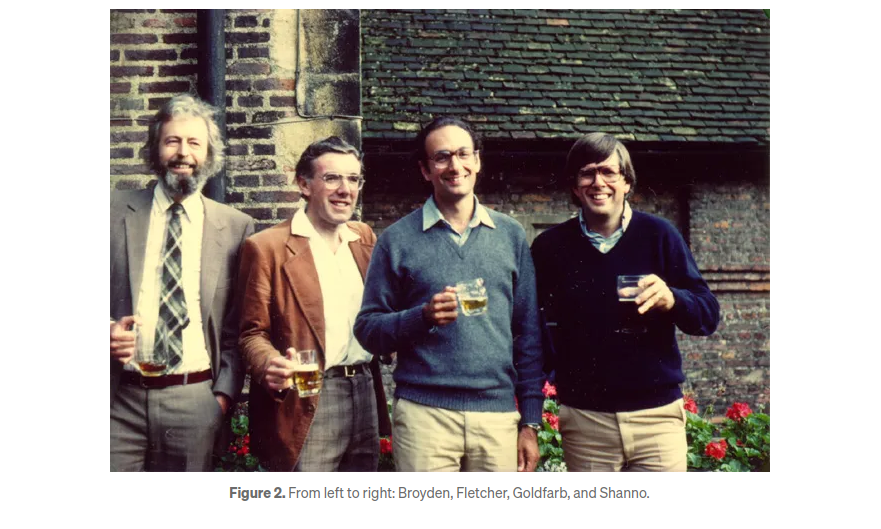

In [19]:
"""
This function aims to compute the next H matrix in the BFGS method.
Inputs:, sk, yk and Hk
Outputs: H_{k+1}
"""
function nextH(sk, yk, Hk)
    pk = 1 ./(transpose(yk)*sk)
    return (I-pk.*sk*transpose(yk))*Hk*(I-pk.*yk*transpose(sk)) + pk.*sk*transpose(sk)

end


"""Here are some tests"""

a = ones((2,1))
b = ones((2,1))
b[1,1] = b[1,1]* 4 


display(nextH(a,b,I))

2×2 Matrix{Float64}:
  0.28  -0.12
 -0.12   1.48

In [20]:
# Solution: copier-coller votre newton_armijo ici et modifier le calcul de la direction avec la méthode de BFGS inverse skip.

function bfgs_quasi_newton_armijo(nlp, x0, verbose::Bool = true, epsilon_abs = 1.0e-6, epsilon_rel = 1.0e-6, max_iter::Int = 100, max_lam::Int = 5, lower_bound = -1e15, max_eval::Int=1000, max_time = 60.0)
  start_time = time()
  historique = [x0]
  xk  = x0 # initialize xk at x0
  fk  = obj(nlp, xk) # evaluate the objective function at xk
  gk = grad(nlp, xk) # get gradient
  gnorm = gnorm0 = norm(gk) # get the norm of the gradient
  k = 0 # round 0
  Hk = I
  error = false
  
  verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
  verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
  while gnorm > epsilon_abs + epsilon_rel * gnorm0 && (time() - start_time) <= max_time  # while the stopping conditions is not met 
    dk = - Hk * gk 
    slope = dot(dk, gk) # slope= direction@gradient

    t = armijo(xk, dk, fk, gk, f)
    last_x = xk
    last_g = gk
    xk += t * dk
    push!(historique, xk)
    fk = obj(nlp, xk)
    gk =  grad(nlp, xk)
    gnorm = norm(gk)
    sk = xk - last_x
    yk = gk - last_g
    if k == 0
      Hk = (transpose(yk)*sk ./ (transpose(yk)*yk)) *I
    end
    
    Hk = nextH(sk, yk, Hk)
    k += 1

    # prints
    if fk <= lower_bound
      xk = -Inf64
      @printf "The problem is unbounded below. \n"
      error = true
      break
    elseif k > max_iter
      @printf "Maximal number of iterations has been reached \n"
      error = true
      break
    elseif (time() - start_time) >= max_time
      @printf "Timeout has been reached"
      error = true
      break
    
    elseif neval_obj(nlp) > max_eval
      @printf "Max number of evaluations has been reached \n"
      error = true
      break
    end
    verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
  end
  if error == false
    println("An optimal solution has been found in $(time() - start_time) seconds")
  else
    println("An error occured during solving")
  end
  
  return xk, obj(nlp, xk), historique
end


bfgs_quasi_newton_armijo (generic function with 9 methods)

In [21]:
#Test
f(x) = x[1]^2 * (2*x[1] - 3) - 6*x[1]*x[2] * (x[1] - x[2] - 1)
x0 = zeros(2)
x0[1] = 1.5
x0[2] = 0.5
nlp = ADNLPModel(f, x0)

arg, star = bfgs_quasi_newton_armijo(nlp, x0)
print("argmin est $arg \n")
println("On trouve une fonction objectif de $star ")

 k        fk ||∇f(x)||
 0  0.00e+00   4.5e+00
 1 -3.73e-01   4.2e+00 8.8e-02 
 2 -7.22e-01   1.4e+00 1.0e+00 
 3 -8.44e-01   9.3e-01 1.0e+00 
 4 -9.83e-01   4.6e-01 1.0e+00 
 5 -9.98e-01   2.3e-01 1.0e+00 
 6 -1.00e+00   7.9e-02 1.0e+00 
 7 -1.00e+00   1.3e-02 1.0e+00 
 8 -1.00e+00   9.1e-04 1.0e+00 
 9 -1.00e+00   1.3e-04 1.0e+00 
10 -1.00e+00   6.7e-06 1.0e+00 
11 -1.00e+00   1.1e-07 1.0e+00 
An optimal solution has been found in 0.0312349796295166 seconds
argmin est [1.0000000149131603, 1.5213298824643154e-9] 
On trouve une fonction objectif de -0.9999999999999994 


### Exercice 4: application à un problème de grande taille

On va ajouter le package `OptimizationProblems` qui contient, comme son nom l'indique, une collection de problème d'optimisation disponible au format de `JuMP` (dans le sous-module `OptimizationProblems.PureJuMP`) et de `ADNLPModel` (dans le sous-module `OptimizationProblems.ADNLPProblems`).

In [22]:
using ADNLPModels, OptimizationProblems.ADNLPProblems, Random # Attention si vous ne faites pas using ADNLPModels avant ça ne fonctionne pas!

In [23]:
n = 500
model = genrose(n=n)
@test typeof(model) <: ADNLPModel

Test Passed

Si vous le souhaitez, il est possible d'accéder à certaines informations sur le problème en accédant à son meta:

In [24]:
using OptimizationProblems
OptimizationProblems.genrose_meta

Dict{Symbol, Any} with 17 entries:
  :has_equalities_only    => false
  :origin                 => :unknown
  :has_inequalities_only  => false
  :defined_everywhere     => missing
  :has_fixed_variables    => false
  :variable_ncon          => false
  :nvar                   => 100
  :is_feasible            => true
  :minimize               => true
  :ncon                   => 0
  :name                   => "genrose"
  :best_known_lower_bound => -Inf
  :objtype                => :other
  :best_known_upper_bound => 405.106
  :has_bounds             => false
  :variable_nvar          => true
  :contype                => :unconstrained

Résoudre le problème `genrose` et un autre problème de la collection en utilisant vos algorithmes précédents.
Avant d'utiliser l'algorithme on testera que le problème est bien sans contrainte avec:

In [25]:
n = 500
nlp = genrose(n = n)
unconstrained(nlp) #qui retourne vrai si `nlp` est un problème sans contraintes.
v = Vector{Float64}(undef,n)
x0 = rand!(v,-10:10)

# Use previous functions to solve genrose.
println("Genrose (Newton Armijo):")
arg1, star1 = newton_armijo_v2(nlp, x0)
print("argmin est $arg1 \n")
println("On trouve une fonction objectif de $star1 ")


println("Genrose (LDLT Armijo):")
arg2, star2 = newton_ldlt_armijo(nlp, x0)
print("argmin est $arg2 \n")
println("On trouve une fonction objectif de $star2 ")

println("Genrose (Quasi Newton Armijo):")
arg3, star3 = bfgs_quasi_newton_armijo(nlp, x0)
print("argmin est $arg3 \n")
println("On trouve une fonction objectif de $star3 ")

Genrose (Newton Armijo):


 k        fk ||∇f(x)||
 0  1.16e+08   3.8e+06


 1  8.12e+07   8.2e+06 1.0e+00 
 2  1.71e+07   2.5e+06 1.0e+00 


 3  3.22e+06   7.2e+05 1.0e+00 
 4  4.65e+06   7.0e+05 1.0e+00 


 5  4.68e+06   1.2e+06 1.0e+00 
 6  1.65e+09   7.4e+07 1.0e+00 


 7  2.20e+09   1.1e+08 1.0e+00 
 8  1.38e+11   1.9e+09 1.0e+00 


 9  2.61e+11   3.5e+09 1.0e+00 
10  5.16e+10   1.0e+09 1.0e+00 


11  1.02e+10   3.0e+08 1.0e+00 
12  2.16e+09   9.2e+07 1.0e+00 


13  2.61e+09   1.1e+08 1.0e+00 
14  1.37e+10   4.0e+08 1.0e+00 


15  2.07e+13   1.2e+11 1.0e+00 
16  6.77e+14   1.4e+12 1.0e+00 


17  1.60e+16   1.5e+13 1.0e+00 
18  1.16e+17   6.4e+13 1.0e+00 


19  5.17e+17   1.7e+14 1.0e+00 
20  3.35e+25   1.3e+20 1.0e+00 


21  6.62e+24   3.9e+19 1.0e+00 
22  1.31e+24   1.2e+19 1.0e+00 


23  2.58e+23   3.4e+18 1.0e+00 
24  5.10e+22   1.0e+18 1.0e+00 


25  1.01e+22   3.0e+17 1.0e+00 
26  1.99e+21   8.9e+16 1.0e+00 


27  3.93e+20   2.6e+16 1.0e+00 
28  7.80e+19   7.8e+15 1.0e+00 


29  1.54e+19   2.3e+15 1.0e+00 
30  3.05e+18   6.8e+14 1.0e+00 


31  6.02e+17   2.0e+14 1.0e+00 
32  1.19e+17   6.0e+13 1.0e+00 


33  2.35e+16   1.8e+13 1.0e+00 
34  1.05e+16   9.9e+12 1.0e+00 


35  1.13e+17   6.6e+13 1.0e+00 
36  1.30e+17   6.9e+13 1.0e+00 


37  4.84e+21   2.3e+17 1.0e+00 
38  9.56e+20   6.7e+16 1.0e+00 


39  1.89e+20   2.0e+16 1.0e+00 
40  3.77e+19   5.9e+15 1.0e+00 


41  7.89e+18   1.8e+15 1.0e+00 
42  2.20e+18   5.6e+14 1.0e+00 


43  9.24e+17   2.6e+14 1.0e+00 
44  1.00e+18   2.7e+14 1.0e+00 


45  7.35e+17   2.2e+14 1.0e+00 
46  9.18e+17   2.8e+14 1.0e+00 


47  5.60e+17   1.8e+14 1.0e+00 
48  3.82e+17   1.6e+14 1.0e+00 


49  4.66e+17   1.7e+14 1.0e+00 
50  3.50e+17   1.5e+14 1.0e+00 


51  6.91e+16   4.5e+13 1.0e+00 
52  1.87e+16   1.5e+13 1.0e+00 


53  3.69e+15   4.6e+12 1.0e+00 
54  1.47e+17   9.2e+13 1.0e+00 


55  2.44e+30   7.8e+23 1.4e-07 
56  2.16e+43   4.0e+33 2.8e-14 


57  6.59e+56   5.2e+43 1.3e-20 
58  6.30e+69   2.8e+53 1.7e-27 


59  2.43e+83   4.4e+63 7.8e-34 
60  4.72e+96   4.1e+73 1.1e-40 


61 5.92e+109   2.7e+83 2.2e-47 
62 1.01e+123   2.3e+93 6.6e-54 


63 8.74e+135  1.1e+103 1.3e-60 
64 2.46e+149  1.4e+113 6.2e-67 


65 9.39e+162  2.1e+123 1.3e-73 
66 1.77e+176  1.9e+133 1.7e-80 


67 2.03e+189  1.2e+143 3.5e-87 
68 2.66e+202  8.3e+152 1.1e-93 


69 5.22e+215  7.8e+162 3.2e-100 
70 5.22e+215  7.8e+162 1.7e-320 


71 5.22e+215  7.8e+162 1.7e-320 
72 5.22e+215  7.8e+162 1.7e-320 


73 5.22e+215  7.8e+162 1.7e-320 
74 5.22e+215  7.8e+162 1.7e-320 


75 5.22e+215  7.8e+162 1.7e-320 
76 5.22e+215  7.8e+162 1.7e-320 


77 5.22e+215  7.8e+162 1.7e-320 
78 5.22e+215  7.8e+162 1.7e-320 


79 5.22e+215  7.8e+162 1.7e-320 
80 5.22e+215  7.8e+162 1.7e-320 


81 5.22e+215  7.8e+162 1.7e-320 
82 5.22e+215  7.8e+162 1.7e-320 


83 5.22e+215  7.8e+162 1.7e-320 
84 5.22e+215  7.8e+162 1.7e-320 


85 5.22e+215  7.8e+162 1.7e-320 
86 5.22e+215  7.8e+162 1.7e-320 


87 5.22e+215  7.8e+162 1.7e-320 
88 5.22e+215  7.8e+162 1.7e-320 


89 5.22e+215  7.8e+162 1.7e-320 
90 5.22e+215  7.8e+162 1.7e-320 


91 5.22e+215  7.8e+162 1.7e-320 
92 5.22e+215  7.8e+162 1.7e-320 


93 5.22e+215  7.8e+162 1.7e-320 
94 5.22e+215  7.8e+162 1.7e-320 


95 5.22e+215  7.8e+162 1.7e-320 
96 5.22e+215  7.8e+162 1.7e-320 


97 5.22e+215  7.8e+162 1.7e-320 
98 5.22e+215  7.8e+162 1.7e-320 


99 5.22e+215  7.8e+162 1.7e-320 
100 5.22e+215  7.8e+162 1.7e-320 


Maximal number of iterations has been reachedAn error occured during solving
argmin est [-0.9932813049138975, 0.9966415713978573, 0.9983113891750354, 0.9991298991065458, 0.999509426100486, 0.9996413806691116, 0.9995923516941629, 0.9993376243199046, 0.9987488007123864, 0.9975295031545284, 0.9950679226366211, 0.9901367629321274, 0.9803090277883904, 0.9608732410515846, 0.9230024804898164, 0.8513589712134073, 0.7235729091931493, 0.5207131663066151, 0.26369269865190714, 0.0417653685531026, -0.4128258846644456, 0.6785264389344979, 0.8321882062666462, 0.9144212929865908, 0.956860365278263, 0.9783785595229605, 0.9891944514624014, 0.9946075364956063, 0.9973108641151928, 0.9986595181775778, 0.9993320585706775, 0.9996674943781491, 0.999835065716732, 0.9999193576221289, 0.9999629279476508, 0.999987777336028, 1.0000064541487053, 1.0000283900695994, 1.000064662863194, 1.0001335909283764, 1.0002699855389803, 1.0005427364323836, 1.0010896247439303, 1.0021869964419396, 1.0043896861183514, 1.00881261875

 1  7.97e+07   8.2e+06 1.0e+00 
 2  2.49e+07   3.0e+06 1.0e+00 


 3  4.79e+06   9.0e+05 1.0e+00 
 4  1.07e+06   2.7e+05 1.0e+00 


 5  2.10e+05   8.1e+04 1.0e+00 
 6  2.00e+05   7.6e+04 5.9e-02 


 7  1.90e+05   7.2e+04 5.9e-02 
 8  1.25e+05   5.1e+04 4.4e-01 


 9  4.27e+04   2.1e+04 1.0e+00 
10  2.19e+04   1.1e+04 1.0e+00 


11  2.17e+04   1.1e+04 2.3e-03 
12  2.02e+04   1.0e+04 5.9e-02 


13  2.01e+04   1.0e+04 7.7e-03 
14  1.75e+04   9.1e+03 1.3e-01 


15  1.69e+04   8.8e+03 3.9e-02 
16  1.69e+04   8.8e+03 1.3e-04 


17  1.37e+04   7.2e+03 3.0e-01 
18  1.34e+04   7.1e+03 1.7e-02 


19  9.72e+03   6.6e+03 1.0e+00 
20  9.60e+03   6.5e+03 7.7e-03 


21  8.96e+03   6.0e+03 8.8e-02 
22  8.93e+03   6.0e+03 5.1e-03 


23  8.81e+03   5.9e+03 1.2e-02 
24  8.68e+03   5.8e+03 2.6e-02 


25  8.61e+03   5.4e+03 2.0e-01 
26  2.87e+03   1.8e+03 1.0e+00 


27  2.50e+03   1.8e+03 4.4e-01 
28  2.31e+03   1.7e+03 8.8e-02 


29  2.29e+03   1.7e+03 1.2e-02 
30  2.12e+03   1.5e+03 2.0e-01 


31  2.04e+03   1.4e+03 5.9e-02 
32  1.86e+03   1.2e+03 3.0e-01 


33  1.69e+03   1.1e+03 2.0e-01 
34  1.41e+03   9.8e+02 4.4e-01 


35  1.40e+03   9.7e+02 7.7e-03 
36  1.39e+03   9.4e+02 2.0e-01 


37  1.38e+03   9.2e+02 3.9e-02 
38  9.50e+02   4.1e+02 1.0e+00 


39  9.10e+02   3.6e+02 2.0e-01 
40  9.00e+02   3.5e+02 3.9e-02 


41  9.00e+02   3.5e+02 5.9e-02 
42  8.82e+02   4.2e+02 1.3e-01 


43  7.97e+02   5.6e+02 1.0e+00 
44  7.60e+02   4.9e+02 3.9e-02 


45  7.03e+02   4.0e+02 3.0e-01 
46  6.81e+02   4.0e+02 1.7e-02 


47  6.26e+02   2.5e+02 1.0e+00 
48  6.18e+02   2.3e+02 1.3e-01 


49  5.85e+02   1.4e+02 1.0e+00 
50  5.85e+02   1.4e+02 1.7e-02 


51  5.83e+02   1.3e+02 1.3e-01 
52  5.72e+02   6.3e+01 6.7e-01 


53  5.72e+02   6.8e+01 8.8e-02 
54  5.67e+02   6.9e+01 6.7e-01 


55  5.65e+02   8.2e+01 8.8e-02 
56  5.61e+02   5.5e+01 4.4e-01 


57  5.56e+02   4.4e+01 1.0e+00 
58  5.54e+02   4.4e+01 5.9e-02 


59  5.53e+02   4.4e+01 3.0e-01 
60  5.52e+02   4.3e+01 8.8e-02 


61  5.51e+02   4.5e+01 1.3e-01 
62  5.50e+02   4.3e+01 5.9e-02 


63  5.47e+02   4.4e+01 4.4e-01 
64  5.47e+02   6.3e+01 6.7e-01 


65  5.41e+02   5.3e+01 6.7e-01 
66  5.40e+02   5.4e+01 5.9e-02 


67  5.40e+02   5.5e+01 7.7e-03 
68  5.36e+02   5.3e+01 1.0e+00 


69  5.35e+02   6.8e+01 1.3e-01 
70  5.30e+02   6.0e+01 3.0e-01 


71  5.29e+02   5.7e+01 8.8e-02 
72  5.28e+02   5.6e+01 3.0e-01 


73  5.24e+02   4.4e+01 4.4e-01 
74  5.23e+02   4.4e+01 2.6e-02 


75  5.22e+02   3.9e+01 1.2e-02 
76  5.21e+02   3.9e+01 1.7e-02 


77  5.21e+02   4.0e+01 2.6e-02 
78  5.15e+02   3.0e+01 6.7e-01 


79  5.15e+02   3.4e+01 6.8e-04 
80  5.14e+02   3.7e+01 3.0e-01 


81  5.13e+02   3.9e+01 5.9e-02 
82  5.08e+02   3.3e+01 1.0e+00 


83  5.08e+02   4.4e+01 2.6e-02 
84  5.06e+02   4.2e+01 2.0e-01 


85  5.06e+02   4.4e+01 1.3e-01 
86  5.05e+02   4.1e+01 2.0e-01 


87  5.03e+02   3.6e+01 3.0e-01 
88  5.02e+02   3.5e+01 1.3e-01 


89  5.02e+02   3.9e+01 1.2e-02 
90  5.01e+02   5.6e+01 6.7e-01 


91  5.00e+02   6.4e+01 2.0e-01 
92  4.99e+02   6.5e+01 2.6e-02 


93  4.97e+02   5.4e+01 2.0e-01 
94  4.96e+02   5.6e+01 1.2e-02 


95  4.93e+02   8.0e+01 6.7e-01 
96  4.92e+02   7.6e+01 8.8e-02 


97  4.86e+02   5.3e+01 1.0e+00 
98  4.86e+02   6.3e+01 8.8e-02 


99  4.85e+02   6.6e+01 2.6e-02 
100  4.78e+02   2.9e+01 1.0e+00 


argmin est [-0.9932860070360724, 0.9966508886504769, 0.9983299490711212, 0.9991669968940761, 0.999583717953737, 0.999790302139502, 0.9998910113156877, 0.9999366879524209, 0.9999503949450753, 0.999939053718554, 0.9998969381675172, 0.9998027857347652, 0.9996090730029775, 0.9992180699486425, 0.9984327020162719, 0.996857895082907, 0.9937045477455996, 0.9874049968392596, 0.9748770236114406, 0.9501874342658453, 0.9024133341520256, 0.813400136093534, 0.6605284647657861, 0.4364024654122604, 0.17484497271901075, 0.0262239864901911, 0.010601578012409976, 0.010216567837205672, 0.010208591839512702, 0.010208427299898265, 0.01020842390584937, 0.010208423835838589, 0.010208423834394438, 0.010208423834364651, 0.010208423834364034, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.010208423834364022, 0.01020842


Genrose (Quasi Newton Armijo):
 k        fk ||∇f(x)||


 0  1.16e+08   3.8e+06
 1  2.75e+18   2.9e+14 1.2e-02 
 2  1.16e+08   3.8e+06 1.0e+00 
 3  1.16e+08   3.8e+06 1.0e+00 
 4  2.62e+07   1.2e+06 1.0e+00 
 5  1.20e+07   6.9e+05 1.0e+00 
 6  5.27e+06   3.8e+05 1.0e+00 
 7  2.99e+06   2.5e+05 1.0e+00 
 8  1.98e+06   1.8e+05 1.0e+00 
 9  1.50e+06   1.5e+05 1.0e+00 
10  1.31e+06   1.4e+05 1.0e+00 
11  1.31e+06   1.4e+05 1.0e+00 
12  1.31e+06   1.4e+05 1.0e+00 
13  1.31e+06   1.4e+05 1.0e+00 
14  1.31e+06   1.4e+05 1.0e+00 
15  1.31e+06   1.4e+05 1.0e+00 
16  1.31e+06   1.4e+05 1.0e+00 
17  1.31e+06   1.4e+05 1.0e+00 
18  1.31e+06   1.4e+05 1.0e+00 
19  1.31e+06   1.4e+05 1.0e+00 
20  1.30e+06   1.4e+05 1.0e+00 
21  1.29e+06   1.4e+05 1.0e+00 
22  1.27e+06   1.3e+05 1.0e+00 
23  1.21e+06   1.3e+05 1.0e+00 
24  1.06e+06   1.1e+05 1.0e+00 
25  7.59e+05   8.2e+04 1.0e+00 
26  3.99e+05   5.0e+04 1.0e+00 
27  2.08e+05   2.9e+04 1.0e+00 
28  1.38e+05   2.2e+04 1.0e+00 
29  1.29e+05   2.4e+04 1.0e+00 
30  1.29e+05   2.4e+04 1.0e+00 
31  1.29e+05   2.

36  1.29e+05   2.4e+04 1.0e+00 
37  1.28e+05   2.4e+04 1.0e+00 
38  1.28e+05   2.4e+04 1.0e+00 
39  1.28e+05   2.4e+04 1.0e+00 
40  1.27e+05   2.4e+04 1.0e+00 
41  1.26e+05   2.5e+04 1.0e+00 
42  1.22e+05   2.5e+04 1.0e+00 
43  1.12e+05   2.4e+04 1.0e+00 
44  9.43e+04   2.1e+04 1.0e+00 
45  7.10e+04   1.6e+04 1.0e+00 
46  4.81e+04   1.2e+04 1.0e+00 
47  3.07e+04   8.5e+03 1.0e+00 
48  2.30e+04   6.3e+03 1.0e+00 
49  2.13e+04   5.8e+03 1.0e+00 
50  2.11e+04   5.8e+03 1.0e+00 
51  2.10e+04   5.8e+03 1.0e+00 
52  2.10e+04   5.9e+03 1.0e+00 
53  2.10e+04   5.9e+03 1.0e+00 
54  2.10e+04   5.9e+03 1.0e+00 
55  2.10e+04   5.9e+03 1.0e+00 
56  2.10e+04   5.9e+03 1.0e+00 
57  2.10e+04   5.9e+03 1.0e+00 
58  2.10e+04   5.9e+03 1.0e+00 
59  2.10e+04   5.9e+03 1.0e+00 
60  2.10e+04   5.9e+03 1.0e+00 
61  2.10e+04   5.9e+03 1.0e+00 
62  2.10e+04   5.9e+03 1.0e+00 
63  2.09e+04   6.0e+03 1.0e+00 
64  2.08e+04   6.0e+03 1.0e+00 
65  2.04e+04   6.0e+03 1.0e+00 
66  1.95e+04   5.9e+03 1.0e+00 
67  1.76

74  7.55e+03   2.1e+03 1.0e+00 
75  7.55e+03   2.1e+03 1.0e+00 
76  7.55e+03   2.1e+03 1.0e+00 
77  7.55e+03   2.1e+03 1.0e+00 
78  7.55e+03   2.1e+03 1.0e+00 
79  7.55e+03   2.1e+03 1.0e+00 
80  7.55e+03   2.1e+03 1.0e+00 
81  7.55e+03   2.1e+03 1.0e+00 
82  7.55e+03   2.1e+03 1.0e+00 
83  7.55e+03   2.1e+03 1.0e+00 
84  7.54e+03   2.1e+03 1.0e+00 
85  7.54e+03   2.1e+03 1.0e+00 
86  7.54e+03   2.2e+03 1.0e+00 
87  7.53e+03   2.2e+03 1.0e+00 
88  7.51e+03   2.2e+03 1.0e+00 
89  7.45e+03   2.2e+03 1.0e+00 
90  7.30e+03   2.2e+03 1.0e+00 
91  6.96e+03   2.1e+03 1.0e+00 
92  6.29e+03   1.9e+03 1.0e+00 
93  5.37e+03   1.7e+03 1.0e+00 
94  4.52e+03   1.5e+03 1.0e+00 
95  4.03e+03   1.5e+03 1.0e+00 
96  3.88e+03   1.5e+03 1.0e+00 
97  3.86e+03   1.4e+03 1.0e+00 
98  3.86e+03   1.4e+03 1.0e+00 
99  3.85e+03   1.4e+03 1.0e+00 
100  3.85e+03   1.4e+03 1.0e+00 
Maximal number of iterations has been reached 
An error occured during solving
argmin est [-0.6433923843250493, 0.5143869426116469, 0.3

In [26]:
n = 500
nlp = tridia(n = n)
unconstrained(nlp) #qui retourne vrai si `nlp` est un problème sans contraintes.
v = Vector{Float64}(undef,n)
x0 = rand!(v,-5:5)

# Use previous functions to solve genrose.
println("Tridia (Newton Armijo):")
arg1, star1 = newton_armijo_v2(nlp, x0)
print("argmin est $arg1 \n")
println("On trouve une fonction objectif de $star1 \n \n")


println("Tridia (LDLT Armijo):")
arg2, star2 = newton_ldlt_armijo(nlp, x0)
print("argmin est $arg2 \n")
println("On trouve une fonction objectif de $star2  \n \n")

println("Tridia (Quasi Newton Armijo):")
arg3, star3 = bfgs_quasi_newton_armijo(nlp, x0)
print("argmin est $arg3 \n")
println("On trouve une fonction objectif de $star3  \n \n")

Tridia (Newton Armijo):


 k        fk ||∇f(x)||
 0  6.10e+06   2.3e+05


 1  1.24e-25   2.3e-11 1.0e+00 
An optimal solution has been found in 0.439755916595459 seconds
argmin est [1.0000000000000013, 0.5000000000000009, 0.25, 0.1250000000000009, 0.06250000000000022, 0.03125, 0.015625, 0.007812500000000888, 0.003906250000000888, 0.0019531250000011102, 0.0009765625000011102, 0.0004882812500004441, 0.0002441406250004441, 0.00012207031250088818, 6.10351562502167e-5, 3.051757812455591e-5, 1.5258789062002209e-5, 7.629394530361822e-6, 3.8146972654029554e-6, 1.9073486327014777e-6, 9.536743162971817e-7, 4.76837158203125e-7, 2.384185789905402e-7, 1.1920928999487046e-7, 5.960464477539063e-8, 2.9802322387695312e-8, 1.4901160985393463e-8, 7.4505797087454084e-9, 3.7252900345946694e-9, 1.862645149230957e-9, 9.313225746154785e-10, 4.65662175486159e-10, 2.3283153183228933e-10, 1.1641665409456436e-10, 5.820899318109696e-11, 2.910449659054848e-11, 1.4552803406786552e-11, 7.276845792603126e-12, 3.637978807091713e-12, 1.8194334927557065e-12, 9.09803741205735e-13, 4.54747350886

 1  7.08e-26   1.8e-11 1.0e+00 
argmin est [1.0000000000000042, 0.5000000000000036, 0.25000000000000266, 0.1250000000000009, 0.06250000000000044, 0.03125000000000011, 0.015624999999999112, 0.007812499999999112, 0.003906249999999112, 0.0019531249999991118, 0.0009765624999991118, 0.0004882812499991118, 0.00024414062499933387, 0.00012207031249822364, 6.103515624889405e-5, 3.051757812411182e-5, 1.5258789061029883e-5, 7.629394529473643e-6, 3.8146972647368216e-6, 1.907348632479433e-6, 9.53674316493866e-7, 4.76837158203125e-7, 2.384185793236071e-7, 1.1920929043895967e-7, 5.960464566356904e-8, 2.980232283178452e-8, 1.4901161317358146e-8, 7.450581041013038e-9, 3.72529085043048e-9, 1.862645593320167e-9, 9.313230187046884e-10, 4.65662175486159e-10, 2.3283153183228933e-10, 1.1641621000535451e-10, 5.820810500267726e-11, 2.9104274545943554e-11, 1.4552359317576702e-11, 7.276845792603126e-12, 3.638866985511413e-12, 1.8194334927557065e-12, 9.098764410698927e-13, 4.551914400963142e-13, 2.278177646530821

39  8.69e+01   1.9e+02 1.0e+00 
40  7.74e+01   1.8e+02 1.0e+00 
41  6.91e+01   1.7e+02 1.0e+00 
42  6.16e+01   1.6e+02 1.0e+00 
43  5.51e+01   1.5e+02 1.0e+00 
44  4.94e+01   1.4e+02 1.0e+00 
45  4.47e+01   1.2e+02 1.0e+00 
46  4.08e+01   1.1e+02 1.0e+00 
47  3.76e+01   1.0e+02 1.0e+00 
48  3.47e+01   1.0e+02 1.0e+00 
49  3.18e+01   1.0e+02 1.0e+00 
50  2.89e+01   1.0e+02 1.0e+00 
51  2.62e+01   9.5e+01 1.0e+00 
52  2.39e+01   8.9e+01 1.0e+00 
53  2.17e+01   8.5e+01 1.0e+00 
54  1.97e+01   8.3e+01 1.0e+00 
55  1.79e+01   8.0e+01 1.0e+00 
56  1.62e+01   7.6e+01 1.0e+00 
57  1.47e+01   7.3e+01 1.0e+00 
58  1.32e+01   6.9e+01 1.0e+00 
59  1.20e+01   6.5e+01 1.0e+00 
60  1.09e+01   6.0e+01 1.0e+00 
61  9.93e+00   5.7e+01 1.0e+00 
62  9.07e+00   5.4e+01 1.0e+00 
63  8.30e+00   5.1e+01 1.0e+00 
64  7.62e+00   4.7e+01 1.0e+00 
65  7.04e+00   4.4e+01 1.0e+00 
66  6.54e+00   4.0e+01 1.0e+00 
67  6.11e+00   3.8e+01 1.0e+00 
68  5.73e+00   3.6e+01 1.0e+00 
69  5.37e+00   3.5e+01 1.0e+00 
70  5.04

79  3.15e+00   2.4e+01 1.0e+00 
80  2.99e+00   2.3e+01 1.0e+00 
81  2.85e+00   2.3e+01 1.0e+00 
82  2.71e+00   2.2e+01 1.0e+00 
83  2.59e+00   2.0e+01 1.0e+00 
84  2.48e+00   1.9e+01 1.0e+00 
85  2.38e+00   1.8e+01 1.0e+00 
86  2.30e+00   1.7e+01 1.0e+00 
87  2.21e+00   1.7e+01 1.0e+00 
88  2.14e+00   1.6e+01 1.0e+00 
89  2.07e+00   1.5e+01 1.0e+00 
90  2.01e+00   1.5e+01 1.0e+00 
91  1.95e+00   1.5e+01 1.0e+00 
92  1.89e+00   1.5e+01 1.0e+00 
93  1.83e+00   1.5e+01 1.0e+00 
94  1.77e+00   1.5e+01 1.0e+00 
95  1.71e+00   1.4e+01 1.0e+00 
96  1.65e+00   1.4e+01 1.0e+00 
97  1.60e+00   1.4e+01 1.0e+00 
98  1.55e+00   1.3e+01 1.0e+00 
99  1.50e+00   1.3e+01 1.0e+00 
100  1.45e+00   1.3e+01 1.0e+00 
Maximal number of iterations has been reached 
An error occured during solving
argmin est [0.03087853193023663, -0.06485086985419357, -0.10627068967942668, -0.12035590754879566, -0.10616244802037743, -0.08757915455779043, -0.06536920746869569, -0.030429694664456223, 0.015217166983495834, 0.0236

On trouve une fonction objectif de 1.4060082927766637  
 



## Devoir

### Exercice 1


En partant de votre fonction BFGS codé pendant le lab (à finir), écrire une méthode adapté au cas quadratique convexe

$$f(x) = 0.5 x^\top A x - b^\top x$$

---
---

Réponse: 

On reprend la fonction BFGS codé en lab et on modifie le pas de la recherche linéaire pour satisfaire l'expression 

$$\alpha = - \frac{\nabla f(x)^\top d}{d^\top A d} $$

Or, on sait que si la fonction est quadratique, son hessien est exactement la matrice A. D'où on calcule une première fois le Hessien au début de la fonction pour obtenir A et on l'utilise par après pour obtenir la direction et obtenir le $\alpha$ optimal.

#### Exercice 1.1

In [27]:

function bfgs_quadratic(nlp, x0, verbose::Bool = true, epsilon_abs = 1.0e-6, epsilon_rel = 1.0e-6, max_iter::Int = 100, max_lam::Int = 5, lower_bound = -1e15, max_eval::Int=1000, max_time = 60.0)
    start_time = time()
    xk  = x0 # initialize xk at x0
    fk  = obj(nlp, xk) # evaluate the objective function at xk
    gk = grad(nlp, xk) # get gradient
    gnorm = gnorm0 = norm(gk) # get the norm of the gradient
    A = hess(nlp, xk)
    k = 0 # round 0
    Hk = A
    error = false
    
    verbose && @printf "%2s %9s %9s\n" "k" "fk" "||∇f(x)||"
    verbose && @printf "%2d %9.2e %9.1e\n" k fk gnorm
    while gnorm > epsilon_abs + epsilon_rel * gnorm0 && (time() - start_time) <= max_time  # while the stopping conditions is not met 
      dk = - Hk * gk 
      slope = dot(dk, gk) # slope= direction@gradient

      test1 = false
      test2 = false
      if test1
        while slope ≥ -1.0e-4 * norm(dk) * gnorm && lam_counter < max_lam  # ADDED lam_counter
          λ = max(1.0e-3, 10 * λ)
          dk = - ((Hk + λ * I ) \ gk)
          slope = dot(dk, gk)
          lam_counter += 1
          if lam_counter == 5
            dk = -gk
          end
        end
      elseif test2
        dk = -gk
      else
        dk = - Hk * gk 
      end
      

      alpha = - transpose(gk) * dk / (transpose(dk)*A*dk)
      last_x = xk
      last_g = gk
      xk += alpha * dk
      fk = obj(nlp, xk)
      gk =  grad(nlp, xk)
      gnorm = norm(gk)
      Hk = A
      k += 1
  
      # prints
      if fk <= lower_bound
        xk = -Inf64
        @printf "The problem is unbounded below. \n"
        error = true
        break
      elseif k > max_iter
        @printf "Maximal number of iterations has been reached \n"
        error = true
        break
      elseif (time() - start_time) >= max_time
        @printf "Timeout has been reached"
        error = true
        break
      
      elseif neval_obj(nlp) > max_eval
        @printf "Max number of evaluations has been reached \n"
        error = true
        break
      end
      verbose && @printf "%2d %9.2e %9.1e %7.1e \n" k fk gnorm t
    end
    if error == false
      println("An optimal solution has been found in $(time() - start_time) seconds")
    else
      println("An error occured during solving")
    end
    return xk, obj(nlp, xk)
  end
  

bfgs_quadratic (generic function with 9 methods)

#### Exercice 1.2

Tester la méthode sur la matrice A et le vecteur b donné.

---
---


In [28]:
n = 10
A = diagm(-1 => ones(n-1), 0 => 4*ones(n), 1 => ones(n-1))
b = A*[1:n;]

display(A)

display(b)

10×10 Matrix{Float64}:
 4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  4.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  4.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  4.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  4.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  4.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  4.0

10-element Vector{Float64}:
  6.0
 12.0
 18.0
 24.0
 30.0
 36.0
 42.0
 48.0
 54.0
 49.0

On initialise x0 de façon random.

In [29]:

f(x) = 0.5 * transpose(x) * A * x - transpose(b)*x # fonction objectif vue en classe
v = Vector{Float64}(undef,n)
x0 = rand!(v,-5:5)

nlp = ADNLPModel(f, x0);
arg, star = bfgs_quadratic(nlp, x0)


 k        fk ||∇f(x)||
 0  3.67e+02   1.3e+02


 1 -1.05e+03   1.8e+01 8.8e-02 
 2 -1.09e+03   9.0e+00 8.8e-02 
 3 -1.09e+03   5.9e+00 8.8e-02 
 4 -1.10e+03   4.1e+00 8.8e-02 
 5 -1.10e+03   3.0e+00 8.8e-02 
 6 -1.10e+03   2.2e+00 8.8e-02 
 7 -1.10e+03   1.7e+00 8.8e-02 
 8 -1.10e+03   1.3e+00 8.8e-02 
 9 -1.10e+03   9.8e-01 8.8e-02 
10 -1.10e+03   7.5e-01 8.8e-02 
11 -1.10e+03   5.7e-01 8.8e-02 
12 -1.10e+03   4.4e-01 8.8e-02 
13 -1.10e+03   3.4e-01 8.8e-02 
14 -1.10e+03   2.6e-01 8.8e-02 
15 -1.10e+03   2.0e-01 8.8e-02 
16 -1.10e+03   1.5e-01 8.8e-02 
17 -1.10e+03   1.2e-01 8.8e-02 
18 -1.10e+03   9.2e-02 8.8e-02 
19 -1.10e+03   7.2e-02 8.8e-02 
20 -1.10e+03   5.5e-02 8.8e-02 
21 -1.10e+03   4.3e-02 8.8e-02 
22 -1.10e+03   3.3e-02 8.8e-02 
23 -1.10e+03   2.6e-02 8.8e-02 
24 -1.10e+03   2.0e-02 8.8e-02 
25 -1.10e+03   1.6e-02 8.8e-02 
26 -1.10e+03   1.2e-02 8.8e-02 
27 -1.10e+03   9.5e-03 8.8e-02 
28 -1.10e+03   7.4e-03 8.8e-02 
29 -1.10e+03   5.8e-03 8.8e-02 
30 -1.10e+03   4.5e-03 8.8e-02 
31 -1.10e+03   3.5e-03 8.8e-02 
32 -1.10

([1.0000058866425212, 1.999992885990044, 3.0000162193052753, 3.99998731009125, 5.000022185491272, 5.9999851660624755, 7.000021329316577, 7.999987955720115, 9.00001310355338, 9.999995351126369], -1099.9999999977358)

#### Exercice 1.3

Justifier pourquoi $\alpha$ est toujours bien défini théoriquement, i.e. $d^\top A d > 0$ ?

---
---


Puisque $A\succ 0$, peu importe la valeur de $d\in \mathbb{R}^n$, cette expression est supérieure à 0.

Une façon intuitive de le voir, est que c'est la même forme qu'une fonction quadratique $$f(d) = d^\top A d$$ qui est strictement positive si $A\succ 0$, par définition.

### Exercice 2

Dans cet exercice, on veut vérifier la convergence théorique et comparer les algorithmes codés
précédemment sur la minimisation de la fonction Himmelblau , i.e. fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2.

---
---


In [36]:
fH(x) = (x[2] + x[1].^2 - 11).^2 + (x[1] + x[2].^2 - 7).^2

n = 2
v = Vector{Float64}(undef,n)
x0 = rand!(v,-5:5)
nlp = ADNLPModel(fH, x0);


In [37]:
println("Newton armijo")
arg1, star1, histo1 = newton_armijo_v2(nlp, x0)

Newton armijo
 k        fk ||∇f(x)||
 0  6.80e+01   8.9e+00


DimensionMismatch: DimensionMismatch: second dimension of A, 10, does not match length of x, 2

In [38]:
println("LDLt armijo")
arg2, star2, histo2 = newton_ldlt_armijo(nlp, x0);

LDLt armijo
 k        fk ||∇f(x)||
 0  6.80e+01   8.9e+00
 1  6.66e+01   8.5e+00 1.0e+00 
 2  6.34e+01   1.7e+01 1.0e+00 
 3  5.03e+01   3.1e+01 1.0e+00 
 4  3.34e+00   2.1e+01 1.0e+00 
 5  7.01e-02   3.3e+00 1.0e+00 
 6  1.92e-05   5.5e-02 1.0e+00 
 7  1.83e-12   1.7e-05 1.0e+00 
 8  1.85e-26   1.7e-12 1.0e+00 


In [39]:
println("BFGS newton armijo")
arg3, star3, histo3 = bfgs_quasi_newton_armijo(nlp, x0);

BFGS newton armijo
 k        fk ||∇f(x)||
 0  6.80e+01   8.9e+00


DimensionMismatch: DimensionMismatch: second dimension of A, 10, does not match length of x, 2